In [1]:
#!pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


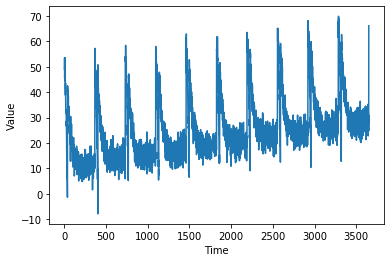

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

Desired output -- a chart that looks like this:

![Chart showing upward trend and seasonailty](http://www.laurencemoroney.com/wp-content/uploads/2019/07/plot1.png)

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [8]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), metrics=['mse'])
model.fit(dataset,epochs=100)



Epoch 1/100
94/94 [==============================] - 1s 6ms/step - loss: 64.9154 - mse: 64.9154
Epoch 2/100
94/94 [==============================] - 1s 7ms/step - loss: 36.0219 - mse: 36.0219
Epoch 3/100
94/94 [==============================] - 1s 7ms/step - loss: 30.4366 - mse: 30.4366
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 28.9851 - mse: 28.9851
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 28.2828 - mse: 28.2828
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 27.5152 - mse: 27.5152
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 26.9999 - mse: 26.9999
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 26.6680 - mse: 26.6680
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 26.2258 - mse: 26.2258
Epoch 10/100
94/94 [==============================] - 1s 6ms/step - loss: 26.0488 - mse: 26.0488
Epoch 11/100
94/94 [===================

94/94 [==============================] - 1s 7ms/step - loss: 22.5653 - mse: 22.5653
Epoch 85/100
94/94 [==============================] - 1s 7ms/step - loss: 22.5429 - mse: 22.5429
Epoch 86/100
94/94 [==============================] - 1s 6ms/step - loss: 22.5373 - mse: 22.5373
Epoch 87/100
94/94 [==============================] - 1s 6ms/step - loss: 22.5855 - mse: 22.5855
Epoch 88/100
94/94 [==============================] - 1s 6ms/step - loss: 22.5149 - mse: 22.5149
Epoch 89/100
94/94 [==============================] - 1s 6ms/step - loss: 22.7205 - mse: 22.7205
Epoch 90/100
94/94 [==============================] - 1s 7ms/step - loss: 22.6439 - mse: 22.6439
Epoch 91/100
94/94 [==============================] - 1s 7ms/step - loss: 22.5176 - mse: 22.5176
Epoch 92/100
94/94 [==============================] - 1s 6ms/step - loss: 22.4277 - mse: 22.4277
Epoch 93/100
94/94 [==============================] - 1s 7ms/step - loss: 22.5261 - mse: 22.5261
Epoch 94/100
94/94 [=======================

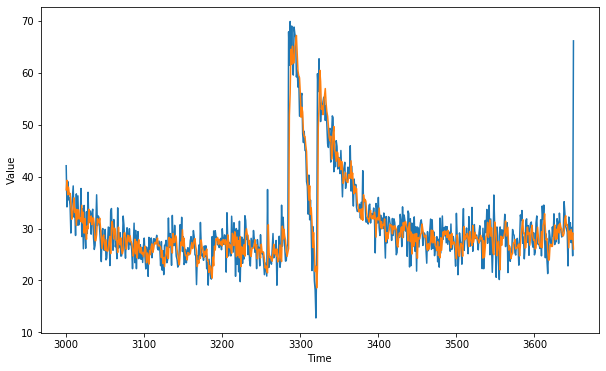

In [9]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3

3.0957954